# YOLOv2

## Prepare Data
### Preparing Pascal VOC 2007
To Prepare the data first go to Examples/Images/DataSets/Pascal and install the data with the install_data.py scripts. 
Then go to Examples/Images/DataSets/Pascal/mappings and run create_mappings.py to preprocess the ground truth boxes.

## Train the model

In [1]:
import os, sys
import Distributed_YOLOv2 as dy
import PARAMETERS as par
import YOLOv2 as yolo2
from ErrorFunction import get_error
from cntk import input_variable, Communicator


In [2]:
model = yolo2.create_yolov2_net(par)
image_input = input_variable((par.par_num_channels, par.par_image_height, par.par_image_width), name="data")
output = model(image_input)  # append model to image input

# input for ground truth boxes
num_gtb = par.par_max_gtbs
gtb_input = input_variable((num_gtb * 5))  # 5 for class, x,y,w,h

if not par.par_boxes_centered:
    original_shape = gtb_input.shape
    new_shape = (num_gtb, 5)
    reshaped = reshape(gtb_input, new_shape)
    xy = reshaped[:,0:2]
    wh = reshaped[:,2:4]
    cls = reshaped[:,4:]
    center_xy = xy + wh*.5
    new_gtb = splice(xy,wh,cls,axis=1)
    gtb_transformed = reshape(new_gtb, gtb_input.shape)
else:
    gtb_transformed = gtb_input

mse = get_error(output, gtb_transformed, cntk_only=False)# + zero

network = {
    'feature': image_input,
    'gtb_in': gtb_input,
    'mse': mse,
    'output': output
}



#from cntk.logging.graph import plot
#plot(output, "./yopar.png")
#plot(network['mse'], "./yolo_mse.png")



In [3]:
data_path = os.path.join(par.par_abs_path, "..", "..", "DataSets","Pascal", "mappings")

train_image_file = os.path.join(data_path, par.par_train_data_file)
train_gt_file = os.path.join(data_path, par.par_train_roi_file)

test_image_file =None # os.path.join(data_path, par.par_test_data_file)
test_gt_file =None # os.path.join(data_path, par.par_test_roi_file)

log_dir = None

In [4]:
base_lr = 1e-3*.5
#par.par_lr_schedule = [base_lr * 0.1]*10 + [base_lr * 1]*30
par.par_lr_schedule = [base_lr]*45 + [base_lr * 0.1]*30 + [base_lr * 0.01]
par.par_max_epochs = 45
par.par_minibatch_size = 128

In [5]:
from cntk.cntk_py import force_deterministic_algorithms
force_deterministic_algorithms()

In [6]:
#training!
# this cell can be executed only once on a kernel!
try:
    output = dy.yolov2_train_and_eval(network, 
                                   train_image_file, train_gt_file,
                                   test_image_file, test_gt_file,
                                   max_epochs=par.par_max_epochs,
                                   log_to_file=log_dir,
                                   num_mbs_per_log=50,
                                   minibatch_size=par.par_minibatch_size,
                                   epoch_size=par.par_epoch_size,
                                   gen_heartbeat=False)

finally:
    Communicator.finalize()
    print("Training finished!")

Finished Epoch[1 of 45]: [Training] loss = 18.170012 * 5120, metric = 1817.00% * 5120 88.620s ( 57.8 samples/s);
Finished Epoch[2 of 45]: [Training] loss = 6.327728 * 4992, metric = 632.77% * 4992 87.164s ( 57.3 samples/s);
Finished Epoch[3 of 45]: [Training] loss = 6.153893 * 4992, metric = 615.39% * 4992 85.441s ( 58.4 samples/s);
Finished Epoch[4 of 45]: [Training] loss = 6.030143 * 4992, metric = 603.01% * 4992 87.033s ( 57.4 samples/s);
Finished Epoch[5 of 45]: [Training] loss = 5.976945 * 4992, metric = 597.69% * 4992 85.402s ( 58.5 samples/s);
Finished Epoch[6 of 45]: [Training] loss = 6.058364 * 4992, metric = 605.84% * 4992 85.406s ( 58.5 samples/s);
Finished Epoch[7 of 45]: [Training] loss = 6.194342 * 5120, metric = 619.43% * 5120 85.568s ( 59.8 samples/s);
Finished Epoch[8 of 45]: [Training] loss = 6.287870 * 4992, metric = 628.79% * 4992 82.940s ( 60.2 samples/s);
Finished Epoch[9 of 45]: [Training] loss = 6.330115 * 4992, metric = 633.01% * 4992 82.947s ( 60.2 samples/s);

In [7]:
output_dir = "."
if output is not None and output_dir is not None:
    save_path = os.path.join(output_dir, "YOLOv2.model")
    output.save(save_path)
    print("Saved model to " + save_path)
trained_model = output

Saved model to ./YOLOv2.model


In [8]:
from cntk import load_model
trained_model = load_model(os.path.join(".", "YOLOv2.model"))

## Evaluate

Box out of bounds: (257,167) (328,288)
Box out of bounds: (213,83) (434,202)
Box out of bounds: (258,114) (388,245)
Box out of bounds: (306,40) (337,342)


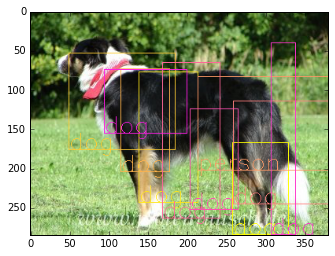

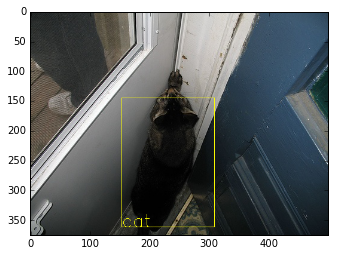

Box out of bounds: (17,-123) (214,401)
Box out of bounds: (-31,-11) (108,443)
Box out of bounds: (69,-77) (161,409)
Box out of bounds: (1,-35) (152,320)
Box out of bounds: (72,-24) (235,340)
Box out of bounds: (8,132) (222,401)
Box out of bounds: (33,144) (430,397)
Box out of bounds: (-142,-10) (296,272)


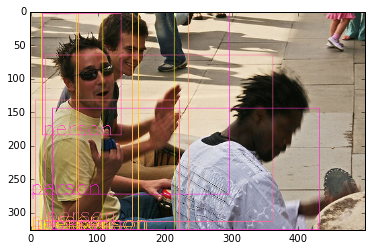

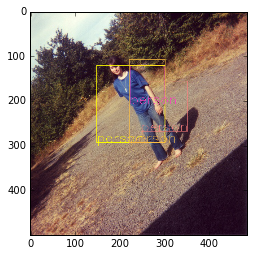

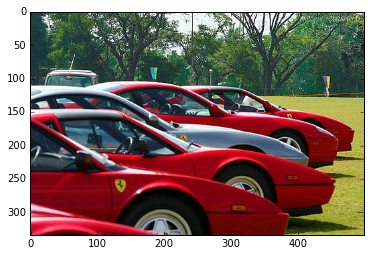

Box out of bounds: (72,67) (312,375)
Box out of bounds: (86,35) (221,413)
Box out of bounds: (157,-36) (458,324)
Box out of bounds: (105,-1) (166,595)
Box out of bounds: (116,-237) (209,736)
Box out of bounds: (99,-35) (226,245)
Box out of bounds: (185,87) (357,430)
Box out of bounds: (85,-80) (295,214)
Box out of bounds: (7,-30) (264,248)
Box out of bounds: (183,75) (359,210)
Box out of bounds: (207,146) (332,400)
Box out of bounds: (238,139) (531,353)
Box out of bounds: (261,199) (431,407)
Box out of bounds: (184,87) (277,458)
Box out of bounds: (217,102) (321,379)
Box out of bounds: (237,159) (300,390)
Box out of bounds: (205,79) (256,423)
Box out of bounds: (97,-162) (365,411)
Box out of bounds: (213,-53) (325,420)
Box out of bounds: (19,140) (211,471)
Box out of bounds: (232,-1) (305,260)
Box out of bounds: (-125,-72) (433,331)
Box out of bounds: (140,14) (245,462)
Box out of bounds: (168,-34) (293,519)
Box out of bounds: (85,155) (228,388)
Box out of bounds: (83,-16) (244,399)
Bo

In [9]:
%matplotlib inline
import evaluate
import cv2
import numpy as np
from cntk import logging

data_input = logging.graph.find_by_name(trained_model, "data")
img_width = data_input.shape[2]
img_height= data_input.shape[1]


obj_min, obj_max=1, 0
data_path= r"../../DataSets/Pascal/VOCdevkit/VOC2007/JPEGImages"
img_list = [18,118,1118,27,2118,4118,1,2,3,4,5,6,7,8,9,10]
# img_list = open(r"..\..\DataSets\Pascal\VOCdevkit\VOC2007\ImageSets\Main\test.txt").read().split()
save_path = os.path.join(".", "outputdir", "results", "pvoc2007")
if not os.path.exists(save_path):
    results_dir = os.path.join(".", "outputdir", "results")
    if not os.path.exists(results_dir):
        output_dir = os.path.join(".", "outputdir")
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        os.mkdir(results_dir)
    os.mkdir(save_path)

for i in range(len(img_list)):
    img_name =  "{:06}.jpg".format(img_list[i])
    img = evaluate.load_image(os.path.join(data_path, img_name))

    preds = evaluate.predictions_for_image(img, trained_model, img_width, img_height)
    preds_nms = evaluate.do_nms(preds)
    #import ipdb;ipdb.set_trace()
    color_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    evaluate.draw_bb_on_image(color_image, preds_nms)

    if i<5:
        evaluate.plot_image(color_image)

    out_img = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)

    evaluate.save_image(out_img, save_path, "bb_"+img_name)

    #import math
    objectnesses = preds[:,4]
    obj_min = np.minimum(obj_min, np.minimum.reduce(objectnesses))
    obj_max = np.maximum(obj_max, np.maximum.reduce(objectnesses))
print((obj_min,obj_max))


In [10]:
dataset_path = os.path.join("..", "..", "DataSets", "Pascal", "mappings")
img_file = os.path.join(dataset_path, "test2007.txt")
gtb_file = os.path.join(dataset_path, "test2007_rois_rel-ctr-wh_noPad_skipDif.txt")
num_images_to_eval = 100


evaluate.eval_map(trained_model, img_file, gtb_file, num_images_to_eval)

ImportError: No module named 'utils.map.map_helpers'